In [1]:
import os
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from collections import defaultdict
from pathlib import Path
import itertools
from typing import Optional
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf

from diverse_gen.utils.exp_utils import get_conf_dir
from diverse_gen.utils.proc_data_utils import get_exp_metrics

In [3]:
MAIN_DIR = "output/mtd/2025-02-27_20-21-48"
GEN_STORIES_DIR = "output/mtd/2025-02-28_15-57-48"

RESULTS_DIR = "results/mtd"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [4]:
METHODS = [
    "TopK_0.1", 
    "DivDis", 
    "FT_Trusted", 
    "Probe_for_Evidence_of_Tamper", 
    "Measurement_Predictor"
]
DATASETS = ["diamonds", "generated_stories"]
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7]


In [5]:
configs = [
    (dataset, method, seed) 
    for dataset, method,  seed in itertools.product(DATASETS, METHODS, SEEDS)
]

In [6]:
import yaml
def get_results(configs: list[tuple[str, str, float, int]], parent_dir: str = MAIN_DIR, select_epoch: bool = True) -> list[dict]:
    results = []
    for dataset, method, seed in configs:
        exp_dir = get_conf_dir((dataset, method, seed), parent_dir)
        metric_file = os.path.join(exp_dir, "metrics.json")
        if not os.path.exists(metric_file):
            continue
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(os.path.join(exp_dir, "config.yaml"), "r") as f:
            config = yaml.safe_load(f)
        # if method.startswith("TopK"):
        #     for key in metrics.keys():
        #         print(key)
        has_val_loss = "val_loss" in metrics.keys()
        if select_epoch: 
            if has_val_loss:
                idxs = [np.argmin(metrics["val_loss"])]
            else:
                idxs = [0] # measaurement predictor, pure eval
        else: 
            idxs = range(len(metrics["val_loss"]))
        
        for idx in idxs: 
            two_heads = "test_acc_1" in metrics.keys()
            if has_val_loss:
                min_val_loss = metrics["val_loss"][idx]
                source_loss = metrics["val_source_loss"][idx]
            else: 
                min_val_loss = 0
                source_loss = 0
            if len(metrics) == 0:
                continue
            test_acc_0 = metrics["test_acc_0"][idx]
            if two_heads:
                test_acc_1 = metrics["test_acc_1"][idx]
                max_test_acc = max(test_acc_0, test_acc_1)
            else:
                max_test_acc = test_acc_0

            test_acc_alt_0 = metrics["test_acc_0_all_sensors"][idx]
            if two_heads:
                test_acc_alt_1 = metrics["test_acc_1_all_sensors"][idx]
                max_test_acc_alt = max(test_acc_alt_0, test_acc_alt_1)
            else:
                max_test_acc_alt = test_acc_alt_0

            test_auroc_0 = metrics["test_auroc_0"][idx]
            if two_heads:
                test_auroc_1 = metrics["test_auroc_1"][idx]
                max_test_auroc = max(test_auroc_0, test_auroc_1)
            else:
                max_test_auroc = test_auroc_0
            test_auroc_0_std = metrics["test_auroc_0_std"][idx]
            if two_heads:
                test_auroc_1_std = metrics["test_auroc_1_std"][idx]
                test_auroc_std = test_auroc_0_std if test_auroc_0> test_auroc_1 else test_auroc_1_std
            else:
                test_auroc_std = test_auroc_0_std


            multi_label_test_acc = np.mean([max_test_acc, max_test_acc_alt])

            result_dict = {
                "Dataset": dataset,
                "Method": method,
                "Seed": seed,
                "val_loss": min_val_loss,
                "source_loss": source_loss,
                "acc": max_test_acc,
                "acc_alt": max_test_acc_alt,
                "multi_label_acc": multi_label_test_acc,
                "auroc": max_test_auroc,
                "auroc_std": test_auroc_std,
                "epoch": idx,
            }
            results.append(result_dict)

    df = pd.DataFrame(results)
    return df

d_1_configs = [(dataset, method, seed) for dataset, method, seed in configs if not (dataset == "generated_stories" and method in ["TopK_0.1", "DivDis"])]
d_2_configs = [(dataset, method, seed) for dataset, method, seed in configs if (dataset == "generated_stories" and method in ["TopK_0.1", "DivDis"])]
df_p1 = get_results(d_1_configs, MAIN_DIR)
df_p2 = get_results(d_2_configs, GEN_STORIES_DIR)
df = pd.concat([df_p1, df_p2])
df.to_csv(os.path.join(RESULTS_DIR, "results.csv"), index=False)

In [15]:
df[(df["Method"] == "TopK_0.1") & (df["Dataset"] == "generated_stories")]

,Dataset,Method,Seed,val_loss,source_loss,acc,acc_alt,multi_label_acc,auroc,auroc_std,epoch
0,generated_stories,TopK_0.1,0,1.307034,1.142010,0.660819,0.865497,0.763158,0.844717,0.047729,3
1,generated_stories,TopK_0.1,1,1.369589,1.179823,0.801170,0.964912,0.883041,0.846442,0.045643,2
2,generated_stories,TopK_0.1,2,1.444018,1.256178,0.649123,0.918129,0.783626,0.683405,0.056526,2
3,generated_stories,TopK_0.1,3,1.451126,1.382568,0.719298,0.947368,0.833333,0.830747,0.045331,3
4,generated_stories,TopK_0.1,4,1.617988,1.401026,0.654971,0.900585,0.777778,0.556148,0.056051,2
5,generated_stories,TopK_0.1,5,1.395603,1.299487,0.461988,0.923977,0.692982,0.621635,0.066606,2
6,generated_stories,TopK_0.1,6,1.201750,1.085295,0.783626,0.929825,0.856725,0.786974,0.055769,3
7,generated_stories,TopK_0.1,7,1.194193,1.012748,0.754386,0.959064,0.856725,0.817828,0.056107,2


In [30]:
METHOD_ORDER = ["Probe_for_Evidence_of_Tamper", "TopK_0.1", "DivDis",  "FT_Trusted", "Measurement_Predictor",]

In [48]:
METHOD_NAME_MAP = {
    "Probe_for_Evidence_of_Tamper": "Probe for \n Evidence of \n Tamper",
    "TopK_0.1": "TopK 0.1",
    "DivDis": "DivDis",
    "Measurement_Predictor": "Measurement \n Predictor",
    "FT_Trusted": "FT \n Trusted",
}

DATASET_NAME_MAP = {
    "diamonds": "Diamonds",
    "generated_stories": "Generated Stories",
}

/tmp/ipykernel_1490210/3305125365.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_data['Method'] = pd.Categorical(dataset_data['Method'], categories=METHOD_ORDER, ordered=True)
/tmp/ipykernel_1490210/3305125365.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([METHOD_NAME_MAP[m] for m in dataset_data['Method']], rotation=0, ha='center', fontsize=6)
/tmp/ipykernel_1490210/3305125365.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

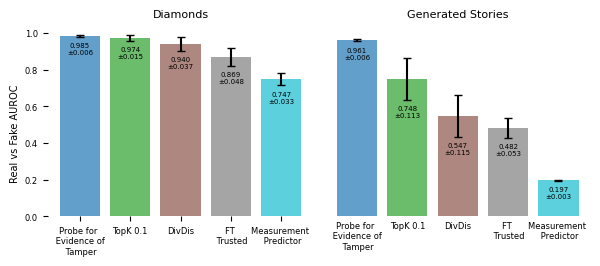

In [ ]:
figsize = (6, 3)
# Group by Dataset and Method and calculate mean and std for auroc
auroc_stats = df.groupby(['Dataset', 'Method'])['auroc'].agg(['mean', 'std']).reset_index()

# Create a figure with subplots for each dataset
datasets = df['Dataset'].unique()
fig, axes = plt.subplots(1, len(datasets), figsize=figsize, sharey=True)

# Set a color palette for the methods
colors = plt.cm.tab10(np.linspace(0, 1, len(METHODS)))

# Adjust font sizes to fit the smaller figure
plt.rcParams.update({
    'font.size': 7,          # Base font size
    'axes.titlesize': 8,     # Title font size
    'axes.labelsize': 7,     # Axis label font size
    'xtick.labelsize': 6,    # X-tick label font size
    'ytick.labelsize': 6     # Y-tick label font size
})

# Plot each dataset in its own subplot
for i, dataset in enumerate(datasets):
    # Filter data for this dataset
    dataset_data = auroc_stats[auroc_stats['Dataset'] == dataset]
    
    # Sort the data according to METHOD_ORDER
    dataset_data['Method'] = pd.Categorical(dataset_data['Method'], categories=METHOD_ORDER, ordered=True)
    dataset_data = dataset_data.sort_values('Method')
    
    # Create the bar plot
    bars = axes[i].bar(
        dataset_data['Method'], 
        dataset_data['mean'], 
        yerr=dataset_data['std'],
        capsize=3,  # Reduced capsize for smaller figure
        color=colors,
        alpha=0.7
    )
    
    # Add mean and std labels to each bar with smaller font
    for j, bar in enumerate(bars):
        mean_val = dataset_data['mean'].iloc[j]
        std_val = dataset_data['std'].iloc[j]
        # Calculate position below the error bar
        label_y_pos = mean_val - std_val - 0.03  # Slightly reduced padding
        
        axes[i].text(
            bar.get_x() + bar.get_width()/2,
            label_y_pos,
            f"{mean_val:.3f}\n±{std_val:.3f}",
            ha='center',
            va='top',
            fontsize=5,  # Smaller font for the value labels
            rotation=0
        )
    
    # Set title for each subplot with the dataset name
    axes[i].set_title(DATASET_NAME_MAP[dataset], fontsize=8)
    
    # Remove borders (spines) from the plot
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # Remove ticks for the second chart (index 1)
    if i == 1:  # This targets the second subplot (index 1)
        axes[i].tick_params(axis='both', which='both', length=0)
    
    # Rotate x-axis labels for better readability and apply METHOD_NAME_MAP
    axes[i].set_xticklabels([METHOD_NAME_MAP[m] for m in dataset_data['Method']], rotation=0, ha='center', fontsize=6)

    

# Add a common y-label
fig.text(0.005, 0.5, 'Real vs Fake AUROC', va='center', rotation='vertical', fontsize=7)

# Adjust layout with more padding at the bottom for rotated labels
plt.tight_layout(pad=1.2, h_pad=0.5, w_pad=0.5, rect=[0.01, 0.05, 1, 0.95])
plt.savefig(f"{RESULTS_DIR}/auroc_by_method_dataset.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{RESULTS_DIR}/auroc_by_method_dataset.svg", dpi=300, bbox_inches='tight')
plt.show()